Este notebook levanta la carpeta data que se encuentra en el mismo directorio que el propio notebook y a partir de ella genera una csv y procesa los archivos de audio encontrados para generar espectrogramas de mell

# Imports y Parametros

In [1]:
import os
import torch
import torchaudio
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sounddevice as sd

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#

In [3]:
#parametros para los calculos del mell
TARGET_SR = 16000  # Normalmente el audio se sule usar a 16k aunque encontre papers que trabajan a 22050 o a 22k (ver V2)
TARGET_TIME = 10 # duracion esperada para las pistas de audio generadas.
N_FFT = 512  #muestras de la fft
W_LEN = 400  # Numero de muestras para la ventan de la  fft (seg_de_ventan *sr) 
H_LEN = 160 # paso de la ventana entre una fft y la siguiente (paso * sr)
N_MELS = 26
N_MFCC = 13
#se suele usar una ventana de haning

#creo una bariable root la cual se puede cambiar si se quiere trabajar con otro directorio,
# pero a priori se deja en '.' para trabajar desde el directorio local del proyecto
root = os.path.join("..","data")
csvPath = os.path.join("..","csv")
print(os.listdir(csvPath))
csvName = "metaDataMaster.csv"


['metaDataMaster.csv']


# levantando la lista de canciones 

In [4]:
original = pd.read_csv(os.path.join(csvPath,csvName), index_col = "fileTrak")
original.head()

,MFI,artist,album,song,localPath,duracion
fileTrak,,,,,,
/audio/hombre/Imagine Dragons/Evolve/Believer (Kaskade Remix).flac,hombre,Imagine Dragons,Evolve,Believer (Kaskade Remix),/audio/hombre/Imagine Dragons/Evolve,190.893333
/audio/hombre/Imagine Dragons/Evolve/Believer.flac,hombre,Imagine Dragons,Evolve,Believer,/audio/hombre/Imagine Dragons/Evolve,204.346667
/audio/hombre/Imagine Dragons/Evolve/Dancing In The Dark.flac,hombre,Imagine Dragons,Evolve,Dancing In The Dark,/audio/hombre/Imagine Dragons/Evolve,235.426667
/audio/hombre/Imagine Dragons/Evolve/I Don't Know Why.flac,hombre,Imagine Dragons,Evolve,I Don't Know Why,/audio/hombre/Imagine Dragons/Evolve,190.120000
/audio/hombre/Imagine Dragons/Evolve/I'll Make It Up To You.flac,hombre,Imagine Dragons,Evolve,I'll Make It Up To You,/audio/hombre/Imagine Dragons/Evolve,262.600000


In [5]:
list(np.unique(original.artist))

['Ariana Grande',
 'Imagine Dragons',
 'Katy Perry',
 'Metallica',
 'Pink Floyd',
 'System Of A Down',
 'Taylor Swift',
 'Twenty One Pilots']

In [10]:
#Eleccion del subset a usar

df = pd.concat([
    original[original.MFI == 'mujer'],
    original[original.artist == 'Metallica' ], original[original.artist == 'Pink Floyd']
    #original[original.MFI == 'hombre'],
])
#Elimino las canciones que duran menos de 10 segundos
drops = df[df.duracion <= 10]
if len(drops) != 0:
    df = df.drop(drops.index)

In [11]:
classes = list(np.unique(df.artist))
classes

['Ariana Grande', 'Katy Perry', 'Metallica', 'Pink Floyd', 'Taylor Swift']

In [12]:
clas_dist = df.groupby(['artist'])['duracion'].sum()
clas_dist

artist
Ariana Grande     40151.390385
Katy Perry        55384.137809
Metallica        119985.626667
Pink Floyd        70617.560000
Taylor Swift      39442.216398
Name: duracion, dtype: float64

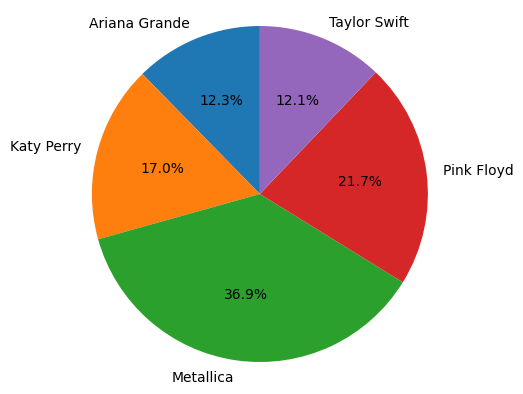

In [13]:
fig, ax = plt.subplots()
ax.pie(clas_dist, labels = clas_dist.index, autopct='%1.1f%%', shadow = False, startangle=90)
ax.axis('equal')
plt.show()


# Definiendo Utilidades

In [14]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    amp_to_db = torchaudio.transforms.AmplitudeToDB()
    ax.imshow(amp_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [15]:
#def stereo_to_mono(signal , keepdim = False):
#  """
#  Colapsa todos los canales de la señal en no solo. (DESCARTADA)
#  """
#  if(signal.shape[0] > 1):
#  signal = torch.mean(signal, dim=0, keepdim= keepdim ) #, keepdim= True
#  return signal

def spliter(tensor, sr, time, truncar = True):
  """
  Recibe un tensor y un tiempo en segundos.
  Retorna el tensro original segmentado en muestras del tiempo recibido.
  En caso de que el recorte no sea exacto, se le agrega zero padding al final.
  """
  num_samples = int(sr * time)
  resto = len(tensor)%num_samples
  if truncar == True:
    splited = torch.split(tensor[:len(tensor) - resto], num_samples)
  else:
    padding = torch.zeros(num_samples - resto)
    splited = torch.split(torch.cat((tensor, padding)), num_samples)
  return splited

def time_fixer(signal, sr, target_time):
  """
  Recibe una señal y un tiempo en segundos.
  En caso de que la señal dure menos de tiempo indicado se le agrega zero padding
  al final.
  En caso de que la señal dure mas de tiempo indicado se le recortan las ultimas muestras
  """
  samples = int(target_time*sr)
  if(signal.shape[0] < samples):
    padding = torch.zeros( samples - signal.shape[0], device= signal.device)
    fixed_signal = torch.cat((signal, padding))
  elif(signal.shape[0] > samples):
    fixed_signal = signal[:samples]
  else:
    fixed_signal = signal
  return fixed_signal


#def preacondicionar_audio(signal, native_sr, target_sr, dur_sample = 10, dur_fix = 5*60):
  """
  (DESCARTADA)
  Se genera un resample de la señal de audio, luego cambia el canal de audio a mono.
  Despues se generan muestras de la señal de audio de 10 segundos y finalmente se fixea la señal de audio a un tiempo de 5 minutos.
  El fixeo a 5 minutos se descarto
  """
  if( native_sr != target_sr):  #resample
    resampler = torchaudio.transforms.Resample(native_sr, target_sr)
    signal = resampler(signal)
  signal = stereo_to_mono(signal)
  muestras = spliter(signal, target_sr, dur_sample)
  fixed_signal = signal #fixed_signal = _time_fixer(signal, target_sr, dur_fix)
  return fixed_signal, muestras, target_sr

def normalizer(signal, threshold = 1e-12):
  """
  Recibe una senial en formato tensor y un valor de tresh_hold. 
  Normaliza la senial a no ser que el valor de pico de la  senial sea menor al valor de threshold
  """
  max_abs_val = signal.abs().max()
  if (max_abs_val > threshold) and (max_abs_val != 1):
    signal = signal / max_abs_val
  return signal
  
#signal, sr = torchaudio.load(fPath)
#signal, sr = preacondicionar_audio(signal, sr, target_sr)
MelCalculator = torchaudio.transforms.MelSpectrogram(sample_rate=TARGET_SR,
                                                       n_fft = N_FFT,
                                                       hop_length = H_LEN,
                                                       win_length= W_LEN,
                                                       n_mels = N_MELS)

MFCCCalculator = torchaudio.transforms.MFCC(sample_rate = TARGET_SR,
                                            n_mfcc = int(N_MFCC),
                                            dct_type = 2,
                                            norm = 'ortho',
                                            log_mels = False,
                                            melkwargs = {"n_fft": N_FFT, "hop_length": H_LEN, "n_mels": N_MELS, "center": False},)


# Resample de las respuestas al impulso RIR

In [17]:
PATH_RIR = os.path.join(root, "RIR")
PATH_RIR_RESAMPLED = os.path.join(root, "RIR_16K")
print(PATH_RIR)
print(PATH_RIR_RESAMPLED)


..\data\RIR
..\data\RIR_16K


In [18]:
os.listdir()

['00_DocGen.ipynb',
 '01_Preprocesado.ipynb',
 '02_DataFramesGenerator.ipynb',
 'desechados']

In [19]:
for f in tqdm(os.listdir(PATH_RIR)) :
    rir, rir_sr = torchaudio.load(os.path.join(PATH_RIR, f))
    rir = rir.to(device)
    #stereo to mono
    rir = torch.mean(rir, dim=0) #, keepdim= True
    #resample
    rir_resampler = torchaudio.transforms.Resample(rir_sr,TARGET_SR).to(device)
    rir = rir_resampler(rir)
    #fixing rir response in 10 seconds
    rir = time_fixer(rir,TARGET_SR,TARGET_TIME)#padding/cut
    #normalizando
    rir = normalizer(rir)
    #save
    rir = rir.unsqueeze(0).cpu()
    save_path = os.path.join(PATH_RIR_RESAMPLED,f)
    torchaudio.save(save_path,rir,TARGET_SR)


  0%|          | 0/325 [00:00<?, ?it/s]

100%|██████████| 325/325 [00:05<00:00, 64.99it/s]


In [20]:
rir.shape

torch.Size([1, 160000])

# Resample de las muestrar de ruido

In [21]:
PATH_NOISE = os.path.join(root, "NOISE")
PATH_NOISE_RESAMPLED = os.path.join(root, "NOISE_16K")
print(PATH_NOISE)
print(PATH_NOISE_RESAMPLED)


..\data\NOISE
..\data\NOISE_16K


In [22]:
for f in tqdm(os.listdir(PATH_NOISE)[1:]) :
    rir, rir_sr = torchaudio.load(os.path.join(PATH_NOISE, f))
    rir = rir.to(device)
    #stereo to mono
    rir = torch.mean(rir, dim=0) #, keepdim= True
    #resample
    rir_resampler = torchaudio.transforms.Resample(rir_sr,TARGET_SR).to(device)
    rir = rir_resampler(rir)
    #fixing rir response in 10 seconds
    rir = time_fixer(rir,TARGET_SR,TARGET_TIME)#padding/cut
    #normalizando
    rir = normalizer(rir)
    #saving
    rir = rir.unsqueeze(0).cpu()
    save_path = os.path.join(PATH_NOISE_RESAMPLED,f)
    torchaudio.save(save_path,rir,TARGET_SR)


100%|██████████| 92/92 [00:02<00:00, 33.54it/s]


# CREANDO UNA BASE DE DATOS DE AUDIO EN 16K

In [16]:
df.head()

,MFI,artist,album,song,localPath,duracion
fileTrak,,,,,,
/audio/mujer/Ariana Grande/Brand New You (From 13)/01. Brand New You (feat. Brynn Williams & Caitlin Gann).flac,mujer,Ariana Grande,Brand New You (From 13),01. Brand New You (feat. Brynn Williams & Cait...,/audio/mujer/Ariana Grande/Brand New You (From...,188.093333
/audio/mujer/Ariana Grande/Brand New You (From 13)/02. A Little More Homework (feat. Graham Phillips) (Single Version).flac,mujer,Ariana Grande,Brand New You (From 13),02. A Little More Homework (feat. Graham Phill...,/audio/mujer/Ariana Grande/Brand New You (From...,302.733333
/audio/mujer/Ariana Grande/Christmas & Chill/01. Intro.flac,mujer,Ariana Grande,Christmas & Chill,01. Intro,/audio/mujer/Ariana Grande/Christmas & Chill,65.693333
/audio/mujer/Ariana Grande/Christmas & Chill/02. Wit It This Christmas.flac,mujer,Ariana Grande,Christmas & Chill,02. Wit It This Christmas,/audio/mujer/Ariana Grande/Christmas & Chill,161.280000
/audio/mujer/Ariana Grande/Christmas & Chill/03. December.flac,mujer,Ariana Grande,Christmas & Chill,03. December,/audio/mujer/Ariana Grande/Christmas & Chill,116.266667


In [23]:
DATA_SET_NAME = "masterDS"
dest_folder = os.path.join(root, "masterDS")

In [21]:
ndf = pd.DataFrame(columns=['MFI', 'artist', 'album', 'song', 'original_path', 'original_file', '16k_path', '16k_file', 'sample_full'])
ndf.set_index('original_file', inplace=True)
ndf.head()

,MFI,artist,album,song,original_path,16k_path,16k_file,sample_full
original_file,,,,,,,,


In [22]:
data = []                                   # lista para guardar toda la metadata para generar un dataframe que permita levantar la info del dataset y que permita generar un dataloader
errors = []                                 # lista para anotar que canciones no se pudieron levantar para depurarlar y/o excluirlas del dataset
for f in tqdm(df.index):

    trakPath = os.path.join(root+ '/' + f)
    try:
        #print('Loading:', trakPath)
        signal, sr = torchaudio.load(trakPath)
        signal = signal.to(device)
    except:
        errors.append(trakPath)
        #print('Error:', trakPath)
        continue
    

    i = 0 # indice para guardar las canciones
    #stereo to mono
    signal = torch.mean(signal, dim=0) #, keepdim= True
    format = f.split(".")[-1]
    #resample
    song_resampler = torchaudio.transforms.Resample(sr,TARGET_SR).to(device)
    signal = song_resampler(signal)
    #normalizando
    signal = normalizer(signal)
    #spliteo la senial en segmentos de 10 segundos
    splited_signal = signal.unfold(0, 10 * TARGET_SR, 10 * TARGET_SR)
    #guardo la senial
    signal = signal.unsqueeze(0).cpu()
    save_path = os.path.join(dest_folder, df.loc[f]['song']+str(i)+"."+format)
    torchaudio.save(save_path,signal,TARGET_SR)
    #Agrego la info de los datos recien generados a la lista para generar el df que se va a usar para el dataset 
    data.append([df.loc[f]['MFI'],
                 df.loc[f]['artist'] ,
                 df.loc[f]['album'], 
                 df.loc[f]['song'], 
                 df.loc[f]['localPath'], 
                 f, 
                 dest_folder, save_path, 'full']) 
    for sample in splited_signal: #podria tener que saltearme la muestra 0 porque suele no tener la voz del cantante
        i += 1
        #guardo la senial
        sample = sample.unsqueeze(0).cpu()
        save_path = os.path.join(dest_folder, df.loc[f]['song']+str(i)+"."+format)
        torchaudio.save(save_path,sample,TARGET_SR)
        #Agrego la info de los datos recien generados a la lista para generar el df que se va a usar para el dataset 
        data.append([df.loc[f]['MFI'],
                    df.loc[f]['artist'] ,
                    df.loc[f]['album'], 
                    df.loc[f]['song'], 
                    df.loc[f]['localPath'], 
                    f, 
                    dest_folder, save_path, 'sample']) 
        #data.append([df.loc[f]['MFI'],df.loc[f]['artist'] , df.loc[f]['album'], df.loc[f]['song'], df.loc[f]['duracion'], df.loc[f]['localPath'], f, melFolder, melSave, mfccFolder, mfccSave, 'sample'])


100%|██████████| 1180/1180 [13:28<00:00,  1.46it/s]


In [24]:
ndf = pd.DataFrame(data, columns=['MFI', 
                                  'artist', 
                                  'album', 
                                  'song', 
                                  'original_path', 
                                  'original_file', 
                                  '16k_path', 
                                  '16k_file', 
                                  'sample_full'
])
error_df = pd.DataFrame(errors, columns=['error_path'])
ndf.head()
ndf.to_csv(os.path.join(csvPath, DATA_SET_NAME + ".csv"), index=False)


In [25]:
error_df.head()

,error_path


# TESTEOS

### OBS: celda de testeo que usa las funciones definidas mas adelante
mel = []
mfcc = []
for c in tqdm(classes):
    file = df[df.artist == c].index[1]
    song, rate = torchaudio.load(root+file)
    song =  stereo_to_mono(song)
    mel.append(MelCalculator(song))
    mfcc.append(MFCCCalculator(song))
print(classes)

MFCCCalculator = torchaudio.transforms.MFCC(sample_rate = TARGET_SR,
                                                n_mfcc = int(N_MFCC),
                                                dct_type = 2,
                                                norm = 'ortho',
                                                log_mels = False,
                                                melkwargs = {"n_fft": N_FFT, "hop_length": H_LEN, "n_mels": N_MELS, "center": False}).to(device)

#load
for file in tqdm(df[df.artist == classes[2]].index) :
    audio_track, song_sr = torchaudio.load(root + file)
    audio_track = audio_track.to(device)
    #stereo to mono
    audio_track = torch.mean(audio_track, dim=0) #, keepdim= True
    #resample
    song_resampler = torchaudio.transforms.Resample(song_sr,TARGET_SR).to(device)
    audio_track = song_resampler(audio_track)

    #load
    RIR_LIST = os.listdir(root + "/RIR")
    sample_rir, rir_sr = torchaudio.load(root+ "/RIR/" + RIR_LIST[1])
    sample_rir = sample_rir.to(device)
    #stereo to mono
    sample_rir = torch.mean(sample_rir, dim=0) #, keepdim= True
    #resample
    rir_resampler = torchaudio.transforms.Resample(rir_sr,TARGET_SR).to(device)
    sample_rir = rir_resampler(sample_rir)
    #spliteo la senial
    splited_audio = audio_track.unfold(0, 10 * TARGET_SR, 10 * TARGET_SR)
    #calculo la fft
    augmented = torchaudio.functional.fftconvolve(splited_audio, sample_rir.unsqueeze(0), "full" )
    #Extraccion de MFCC
    augmented_mfcc = MFCCCalculator(augmented)
    #augmented = augmented.cpu()
    #plot_spectrogram(augmented_mfcc, title = clas_dist.keys()[i])
    #sd.play(augmented, TARGET_SR)
    break
augmented_mfcc = augmented_mfcc.cpu()
plot_spectrogram(augmented_mfcc[0], title = clas_dist.keys()[0])


augmented.shape

splited_audio.shape

TARGET_SR

240000 / 16000

# OBS: celda de testeo que usa las funciones definidas mas adelante 
i = 2
#plot_spectrogram(mel[i], title = clas_dist.keys()[i])
plot_spectrogram(mfcc[i], title = clas_dist.keys()[i])


11 ~ 

k =  1
RIR_LIST = os.listdir(root + "/RIR")
sample_rir, rir_sr = torchaudio.load(root+ "/RIR/" + RIR_LIST[k])
sample_rir.cuda()
sample_rir = stereo_to_mono(sample_rir)
augmented = torchaudio.functional.fftconvolve(song, sample_rir)
rir_mfcc = MFCCCalculator(augmented)
plot_spectrogram(rir_mfcc, title = clas_dist.keys()[i])
sd.play(augmented, rate)


sd.play(augmented, rate)

sd.stop()

# Desechado

## Corriendo acondicionamiento de los datos 

#### M/F/I     indica si el artista es Male, Female, Instrumental
#### artist    indica el nombre del artista o banda
#### album
#### song      indica el nombre de la cncion
#### localPath indica la ruta de la carpeta donde esta contenida la cancion
#### fileTrak  indica el nombre del archivo que contiene la pista de audio
#### fileMel  indica el nombre del espectrograma de mel
#### sample/full indica si el espectrograma es calculado respecto a toda la cancion o respecto a un sample de 10 seg
ndf = pd.DataFrame(columns=['MFI', 'artist', 'album', 'song','localPath', 'fileTrak', 'Mel26', 'MCC13', 'sample_full'])
ndf.set_index('fileTrak', inplace=True)


def save_transform(signal, transform, fName, foldName, FORCE = False, Full = False):
    if( not os.path.isdir(foldName)): #si no existe la carpeta la creo
        os.mkdir(foldName)
    if((not os.path.isfile(fName)) or FORCE): #Calculo el mel si la cancion no esta previamente cargada o si se indico FORCE ## ERROR
        toSave = transform(signal)
        torch.save(toSave, fName)

melFolder = root + '/' + 'M26_noise'        #Carpeta donde se guardan los mel
mfccFolder = root + '/' + 'MFCC13_noise'    # Carpeta donde se guardan los mfcc
FORCE = False
data = []                                   # lista para guardar toda la metadata para generar un dataframe que permita levantar la info del dataset y que permita generar un dataloader
errors = []                                 # lista para anotar que canciones no se pudieron levantar para depurarlar y/o excluirlas del dataset
for f in tqdm(df.index):

    trakPath = root+ '/' + f
    try:
        #print('Loading:', trakPath)
        signal, sr = torchaudio.load(trakPath)
    except:
        errors.append(trakPath)
        #print('Error:', trakPath)
        continue
    
    signal, muestras, sr = preacondicionar_audio(signal, sr, TARGET_SR)
    melIndex = 0

    
    fileMel = df.loc[f]['song'] + ' ' + str(melIndex) +'.pt'    # Genero el nombre para el archivo del MEL  a generar
    melSave =  melFolder + '/' + fileMel                        # Path donde se guarda el archivo
    save_transform(signal, MelCalculator, melSave, melFolder, FORCE = FORCE, Full = True) #aplico el melCalculator a toda la cancion y luego la guardo en el archivo que se consiguio 2 lineas arriba

    fileMfcc = df.loc[f]['song'] + ' ' + str(melIndex) +'.pt'   # Repito el proceso pero esta vez para el MFCC
    mfccSave =  mfccFolder + '/' + fileMfcc #
    save_transform(signal, MFCCCalculator, mfccSave, mfccFolder, FORCE = FORCE, Full = True)

    data.append([df.loc[f]['MFI'],
                 df.loc[f]['artist'] , 
                 df.loc[f]['album'], 
                 df.loc[f]['song'], 
                 df.loc[f]['duracion'], 
                 df.loc[f]['localPath'], 
                 f, melFolder, melSave, mfccFolder, mfccSave, 'full']) #Agrego la info de los datos recien generados a la lista para generar el df que se va a usar para el dataset 

    for sample in muestras: #podria tener que saltearme la muestra 0 porque suele no tener la voz del cantante
        melIndex += 1
        fileMel = df.loc[f]['song'] + ' ' + str(melIndex) +'.pt' #
        melSave =  melFolder + '/' + fileMel #
        save_transform(sample, MelCalculator, melSave, melFolder, FORCE = FORCE, Full = False)
        
        fileMfcc = df.loc[f]['song'] + ' ' + str(melIndex) +'.pt' #
        mfccSave =  mfccFolder + '/' + fileMfcc #
        save_transform(sample, MFCCCalculator, mfccSave, mfccFolder, FORCE = FORCE, Full = False)
        data.append([df.loc[f]['MFI'],df.loc[f]['artist'] , df.loc[f]['album'], df.loc[f]['song'], df.loc[f]['duracion'], df.loc[f]['localPath'], f, melFolder, melSave, mfccFolder, mfccSave, 'sample'])



ndf = pd.DataFrame(data, columns=['MFI', 'artist', 'album', 'song', 'duracion', 'localPath', 'fileTrak', 'melFolder', 'fileMel', 'mfccFolder', 'fileMfcc', 'sample_full'])
error_df = pd.DataFrame(errors, columns=['error_path'])
ndf.head()

for error in errors:
    print(error)

ndf.to_csv(f"{root}/woman_noise.csv", index=False)
error_df.to_csv(f'{root}/errors.csv', index=False)

## Reconstructor

import numpy as np
import matplotlib.pyplot as plt
import librosa

os.listdir(root + '/data')

i_sample = 5
mel_recuperado = torch.load(root + df.at[i_sample, 'localPath'] + '/' + df.at[i_sample, 'fileMel'])
print(mel_recuperado.shape)

plt.figure(figsize= (14, 5))
librosa.display.specshow(librosa.power_to_db(mel_recuperado), sr=target_sr, hop_length=512, x_axis='time', y_axis='mel')